In [1]:
import os
import sys
import pathlib
import glob

root = pathlib.Path("..").resolve()
output_dir = os.path.join(root, "test", "output")

# scientific packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# load data
flow_dt_sensitivity = pd.read_pickle(os.path.join(output_dir,"flow_dt_sensitivity.pkl"))
courant_dt_sensitivity = pd.read_pickle(os.path.join(output_dir,"courant_dt_sensitivity.pkl"))
flow_augment_sensitivity = pd.read_pickle(os.path.join(output_dir,"flow_augment_sensitivity.pkl"))
courant_augment_sensitivity = pd.read_pickle(os.path.join(output_dir,"courant_augment_sensitivity.pkl"))

# The shape of outflow hydrographs are sensitive to timestep on the existing RouteLink
- The green line shows a hydrograph simulated with a 300 second (5 minute) timestep. This is the timestep currently used in the operational implementation of Muskingum-Cunge routing in the National Water Model v2.1
- As we decrease the simulation timestep, hydrographs shift forward in time, exhibiting earlier and higher peak flows.
- Reducing the timestep to 10 seconds causes the peak flow to happen 2.2 hours earlier than the 300 second timestep simulation. 

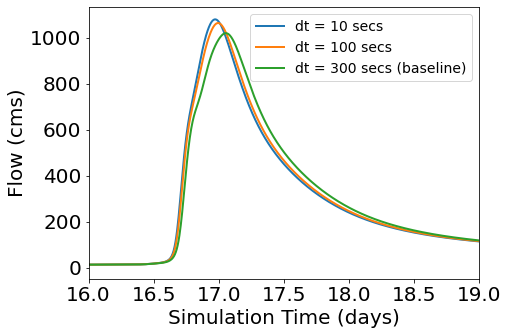

,Peak Time (hrs)
dt (secs),
10,25907.9112
100,25524.3168
300,24465.9912


In [16]:
df_plot = (flow_dt_sensitivity.
             reset_index().
             pivot(index = "Simulation Time (dys)", columns = "dt (secs)", values = "Flow (cms)").
             rename(columns = {10:"dt = 10 secs",
                               100:"dt = 100 secs",
                               300: "dt = 300 secs (baseline)"})
            )

ax = df_plot.plot(
    xlim = [16,19],
    figsize = (7,5),
    linewidth = 2,
    fontsize = 20
)
ax.set_ylabel("Flow (cms)", fontsize = 20)
ax.set_xlabel("Simulation Time (days)", fontsize = 20)
plt.legend(fontsize = 14)
plt.savefig("fig1-flow_dt_sensitivity.png", dpi = 150, facecolor='w', edgecolor='w', bbox_inches = "tight")
plt.show()

# quantify change in peakflow timing
peakflow_timing = (flow_dt_sensitivity.
                   reset_index().
                   set_index("Simulation Time (dys)").
                   groupby(['dt (secs)'])['Flow (cms)'].
                   max().
                   reset_index().
                   rename(columns = {'Flow (cms)':'Peak Time (dys)'}).
                   assign(Peak_Time_hrs = lambda x: x['Peak Time (dys)']*24).
                   rename(columns = {'Peak_Time_hrs':"Peak Time (hrs)"}).
                   drop('Peak Time (dys)', axis = 1).
                   set_index('dt (secs)')
                  )

display(peakflow_timing)

# Numerical instabilities cause differences in hydrograph shapes across simulation timeteps
- With a 300 second timestep on the existing RouteLink domain, Courant vioations occur in 3.7% of time/space nodes. The average magnitude of these violations is ~3, meaning that the average Courant number in violating time/space nodes is ~4.
- Reducing the timestep from 300 seconds, to 100 and 10 seconds reduces the frequency of Courant violations to 1% and 0.06% of time/space nodes respectively. 

In [32]:
display(courant_dt_sensitivity.
          drop(['n_violation'], axis = 1).
          reset_index().
          rename(columns = {'av_violation':'Av. magnitude of Courant violation',
                            'pct_violation':'% time/space nodes whith Courant > 1'}).
        set_index('dt (secs)')
         )

,Av. magnitude of Courant violation,% time/space nodes whith Courant > 1
dt (secs),,
300,3.038528,3.791961
100,2.410522,1.050970
10,0.304425,0.060120


# RouteLink augmentation reduces Courant violations by increasing the minimum segment length
- We applied an algorithm that post processes RouteLink data in a way the eliminates the presence of segments shorter than a user-specified threshold length. 
    - The algorithm sequentially merges together short segments within the same reach, prunes short headwaters, and snaps together junctions separated by short reaches. 
- Decreasing the minimum segment length reduces the frequency and magnitude of Courant violations. 
- A minimum segment length of 500 meters reduces the frequency and magnitude of Courant violations below that of the 10 second simulation on the current RouteLink network. 

In [5]:
m = "prune_snap_merge"
display(courant_augment_sensitivity.
     reset_index().
     query('method == @m').
     drop(['method'], axis = 1).
     rename(columns = {'threshold_length':'Minimum length (m)',
                       'n_violation':'Number of time/space nodes with Courant > 1',
                       'av_violation':'Av. magnitude of Courant violation',
                       'pct_violation':'% time/space nodes whith Courant > 1'
                      }
           ).
        set_index('Minimum length (m)')
    )

,Number of time/space nodes with Courant > 1,Av. magnitude of Courant violation,% time/space nodes whith Courant > 1
Minimum length (m),,,
0,363009.0,3.038528,3.791961
100,172513.0,0.726370,1.887220
250,15518.0,0.233329,0.213056
500,1217.0,0.200554,0.019951
750,410.0,0.133385,0.007818
1000,3.0,0.012793,0.000065


# RouteLink augmentation changes hydrograph shape
- Change in hydrograph shape are attributable to:
    1. fewer numerical errors
    2. rearrangement of network architecture, and
    3. destination of lateral inflows

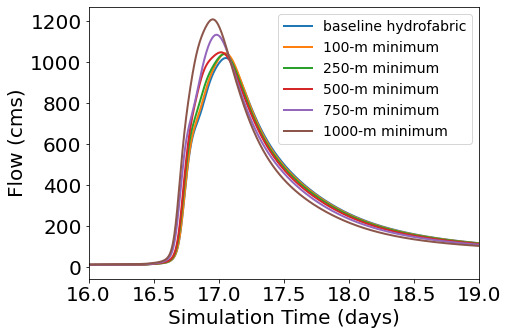

In [8]:
m = "prune_snap_merge"
df_plot = (flow_augment_sensitivity.
             reset_index().
             query('method == @m').
             drop(['method'], axis = 1).
             pivot(index = "Simulation Time (dys)", columns = "threshold_length", values = "Flow (cms)").
             rename(columns = {0:"baseline hydrofabric",
                               100:"100-m minimum",
                               250:"250-m minimum",
                               500:"500-m minimum",
                               750:"750-m minimum",
                               1000:"1000-m minimum",})
            )

ax = df_plot.plot(
    xlim = [16,19],
    figsize = (7,5),
    linewidth = 2,
    fontsize = 20
)
ax.set_ylabel("Flow (cms)", fontsize = 20)
ax.set_xlabel("Simulation Time (days)", fontsize = 20)
plt.legend(fontsize = 14)
plt.savefig("fig2-flow_augment_sensitivity.png", dpi = 150, facecolor='w', edgecolor='w', bbox_inches = "tight")
plt.show()

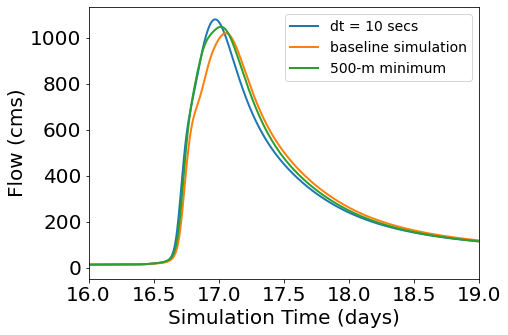

In [15]:
m = "prune_snap_merge"
t = 500

df_plot = (flow_dt_sensitivity.
                 reset_index().
                 rename(columns = {"dt (secs)":"dt"}).
                 query('dt == 10 or dt == 300').
                 pivot(index = "Simulation Time (dys)", columns = "dt", values = "Flow (cms)").
                 rename(columns = {10:"dt = 10 secs", 300:"baseline simulation"}).
                 join(flow_augment_sensitivity.query('method == @m and (threshold_length == @t)').set_index("Simulation Time (dys)").rename(columns = {"Flow (cms)":"500-m minimum"})[["500-m minimum"]],
                       on = "Simulation Time (dys)", 
                       how = "left", lsuffix='_left', 
                       rsuffix='_right')
            )

ax = df_plot.plot(
    xlim = [16,19],
    figsize = (7,5),
    linewidth = 2,
    fontsize = 20
)
ax.set_ylabel("Flow (cms)", fontsize = 20)
ax.set_xlabel("Simulation Time (days)", fontsize = 20)
plt.legend(fontsize = 14)
plt.savefig("fig3-sensitivity_comparision.png", dpi = 150, facecolor='w', edgecolor='w', bbox_inches = "tight")
plt.show()